#                                         Highway inspection and maintenance by YOLO model

In [ ]:
# Check GPU Status in Google Colob or Local Machine
!nvidia-smi  # For GPU


Thu Jan 30 07:37:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

!nvidia-smi  # For GPU


# **Cuda**

In [ ]:
# Check if GPU is available with pytorch
import torch
print(torch.cuda.is_available()) # True if GPU is avilable

True


# **Mount Drive**

In [ ]:
from google.colab import drive  # for mounting google drive if needed
drive.mount('/content/drive')

# **Required Libraries for Data Conversion**

In [15]:
import locale   # for setting encoding to UTF-8
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
# Install necessary libraries for YOLOv8 and COCO dataset handling
!pip install ultralytics
!pip install pycocotools

# **code for conversion**

In [ ]:
import os # for file handling
import json # for JSON file handlind
from pathlib import Path # for path handling

# Define a function to convert COCO annotations to YOLOv8 format
def coco_to_yolo_segmentation(coco_json_path, images_dir, output_labels_dir):
    """
    Convert COCO JSON annotations to YOLOv8 segmentation format.
    Args:
        coco_json_path (str): Path to the COCO JSON file.
        images_dir (str): Path to the images directory.
        output_labels_dir (str): Path to the output labels directory.
    """
    # Load the COCO JSON annotation file
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    # Create a mapping of COCO category IDs to YOLO class indices
    category_mapping = {category['id']: idx for idx, category in enumerate(coco_data['categories'])}

    # Process each image in the COCO dataset
    for image in coco_data['images']:
        image_id = image['id']
        image_filename = image['file_name']

        # Read image dimensions
        img_width, img_height = image['width'], image['height']

        # Get all annotations corresponding to this image
        annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]

        # Define the output label file path
        label_path = os.path.join(output_labels_dir, f"{Path(image_filename).stem}.txt")
        os.makedirs(output_labels_dir, exist_ok=True)

        # Open the label file for writing YOLO format annotations
        with open(label_path, 'w') as label_file:
            for ann in annotations:
                category_id = ann['category_id']    # Get COCO category ID
                class_idx = category_mapping[category_id] # Get corresponding YOLO class index

                # Extract segmentation points
                segmentation = ann['segmentation'][0]  # Assuming one segmentation per annotation

                # Normalize segmentation points to YOLO format (scaling between 0 and 1)
                normalized_seg = [
                    point / dim for point, dim in zip(segmentation, [img_width, img_height] * (len(segmentation) // 2))
                ]
                # Ensure all points are within the valid range [0,1] to avoid annotation errors
                normalized_seg = [min(max(point, 0), 1) for point in normalized_seg]

                # Convert list to space-separated string format for YOLO
                normalized_seg_str = " ".join(map(str, normalized_seg))

                # Write the formatted annotation to the label file
                label_file.write(f"{class_idx} {normalized_seg_str}\n")

    print(f"Annotations for {coco_json_path} converted and saved to {output_labels_dir}")

# Define the paths for your dataset
base_dir = '/content/drive/MyDrive/all_aug_anno_json_proj/Dataset/annoated_json'  # Path cotnaining COCO augmented annotations
output_base_dir = '/content/drive/MyDrive/all_aug_anno_json_proj/Dataset/Yolo_conversions'  # New directory for converted annotations
splits = ['test','train', 'val']   # Splits in the dataset

# Convert COCO annotations to YOLOv8 format for each split
for split in splits:
    coco_json_path = f"{base_dir}/{split}/{split}_annotations.json"  # Path to COCO JSON for each split
    images_dir = f"{base_dir}/{split}/images"    # Image directory path for each split
    output_labels_dir = f"{output_base_dir}/{split}/labels"  # New directory for labels

    # Convert COCO annotations to YOLOv8 format
    coco_to_yolo_segmentation(coco_json_path, images_dir, output_labels_dir)

print("COCO annotations successfully converted to YOLOv8 format and stored separately!")


Annotations for /content/drive/MyDrive/all_aug_anno_json_proj/Dataset/annoated_json/test/test_annotations.json converted and saved to /content/drive/MyDrive/all_aug_anno_json_proj/Dataset/Yolo_conversions/test/labels
Annotations for /content/drive/MyDrive/all_aug_anno_json_proj/Dataset/annoated_json/train/train_annotations.json converted and saved to /content/drive/MyDrive/all_aug_anno_json_proj/Dataset/Yolo_conversions/train/labels
Annotations for /content/drive/MyDrive/all_aug_anno_json_proj/Dataset/annoated_json/val/val_annotations.json converted and saved to /content/drive/MyDrive/all_aug_anno_json_proj/Dataset/Yolo_conversions/val/labels
COCO annotations successfully converted to YOLOv8 format and stored separately!


# **Creating yaml**


In [ ]:
import os  # Import OS module for file and directory operations
import json  # Import JSON module to handle COCO annotation files
import yaml  # Import YAML module to save dataset configuration in YOLO format
# Prompt user to enter the path of the COCO JSON file ( combined augmented annotations)
coco_json_path = input("Enter the full path of your COCO JSON file: ")  # Example: '/content/drive/MyDrive/splitted_dataset/train/combined_augmented_json.json'

# Open and load the COCO JSON file into a Python dictionary
with open(coco_json_path, 'r') as f:
    coco_data = json.load(f)    # Load JSON content into coco_data variable

# Extract class names from the 'categories' field in the COCO dataset
class_names = [category['name'] for category in coco_data['categories']]   # This creates a list of class names present in the dataset

# Prompt user to enter the base directory where the converted dataset will be saved
output_base_dir = input("Enter the base output directory for the converted dataset (e.g., '/content/drive/MyDrive/YOLOv8_converted/'): ")

# Define the structure for the dataset.yaml file needed for YOLO training
dataset_yaml = {
    'train': os.path.join(output_base_dir, 'train/images'),  # Path to training images
    'val': os.path.join(output_base_dir, 'val/images'),      # Path to validation images
    'test': os.path.join(output_base_dir, 'test/images'),    # Path to test images
    'nc': len(class_names),  # Number of object classes in the dataset
    'names': class_names  # List of class names extracted from COCO Json
}

# Define the full path where dataset.yaml will be saved
yaml_output_path = os.path.join(output_base_dir, 'dataset.yaml')

# Open the file in write mode and save the dataset configuration in YAML format
with open(yaml_output_path, 'w') as yaml_file:
    yaml.dump(dataset_yaml, yaml_file) # Save in readable YAML format

# Print the output location of the saved YAML file
print(f"YAML file has been saved to: {yaml_output_path}")


Enter the full path of your COCO JSON file: /content/drive/MyDrive/all_aug_anno_json_proj/Dataset/annoated_json/all_augmented_annotations.json
Enter the base output directory for the converted dataset (e.g., '/content/drive/MyDrive/YOLOv8_converted/'): /content/drive/MyDrive/all_aug_anno_json_proj/Dataset/Yolo_conversions
YAML file has been saved to: /content/drive/MyDrive/all_aug_anno_json_proj/Dataset/Yolo_conversions/dataset.yaml


# **Import the required libraries and initialize the model**

In [ ]:
!pip install ultralytics
from ultralytics import YOLO # Import YOLOv8 model from Ultralytics

# Load the YOLOv8 segmentation model
model = YOLO("yolov8s-seg.pt") # Load the pre-trained YOLOv8 model

# **Train the model**

In [5]:
# Train the YOLOv8 model
results = model.train(
    data = "/content/drive/MyDrive/all_aug_anno_json_proj/Dataset/Yolo_conversions/dataset.yaml",  # Path to dataset YAML file
    epochs = 15,           # Number of epochs
    imgsz = 640,           # Image size
    batch = 6,             # Batch size
    lr0 = 0.001,            # Initial learning rate
    workers = 2,           # Number of data loader workers
    optimizer = "AdamW",     # Optimizer (SGD or Adam)
    patience = 5,         # stop if no improvement for 5 epochs
    device = 0        # Device to use (0 for GPU, 'cpu' for CPU)
)

Ultralytics 8.3.69 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=yolov8s-seg.pt, data=/content/drive/MyDrive/all_aug_anno_json_proj/Dataset/Yolo_conversions/dataset.yaml, epochs=15, time=None, patience=5, batch=6, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=2, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, sav

train: Scanning /content/drive/MyDrive/all_aug_anno_json_proj/Dataset/Yolo_conversions/train/labels.cache... 7294 images, 787 backgrounds, 0 corrupt: 100%|██████████| 7311/7311 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/all_aug_anno_json_proj/Dataset/Yolo_conversions/val/labels.cache... 2084 images, 207 backgrounds, 0 corrupt: 100%|██████████| 2092/2092 [00:00<?, ?it/s]


Plotting labels to runs/segment/train4/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.000515625), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train4
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/15      2.32G      1.345      2.671      2.349      1.494          9        640: 100%|██████████| 1219/1219 [05:52<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 175/175 [00:53<00:00,  3.27it/s]


                   all       2092       2832      0.515      0.392      0.375      0.241      0.434       0.37      0.342      0.216

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/15      2.27G      1.336      2.411      1.999      1.478         19        640: 100%|██████████| 1219/1219 [05:37<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 175/175 [00:50<00:00,  3.49it/s]


                   all       2092       2832      0.428      0.504      0.459      0.304      0.417      0.474       0.43      0.283

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/15      2.27G      1.246      2.215      1.808      1.414          6        640: 100%|██████████| 1219/1219 [05:32<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 175/175 [00:50<00:00,  3.43it/s]


                   all       2092       2832       0.56      0.581      0.561      0.376      0.547      0.558      0.532      0.348

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/15       2.3G      1.157       2.02      1.616      1.347         10        640: 100%|██████████| 1219/1219 [05:28<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 175/175 [00:50<00:00,  3.44it/s]


                   all       2092       2832       0.61      0.602       0.62       0.44      0.606      0.584      0.595      0.391

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/15      2.25G      1.073      1.854      1.434      1.291         13        640: 100%|██████████| 1219/1219 [05:28<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 175/175 [00:51<00:00,  3.38it/s]


                   all       2092       2832      0.687      0.652      0.705      0.509        0.7      0.623      0.682      0.452
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/15      2.23G      1.045      1.606      1.255      1.347          6        640: 100%|██████████| 1219/1219 [05:13<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 175/175 [00:52<00:00,  3.36it/s]


                   all       2092       2832      0.683      0.705      0.747      0.546      0.676      0.695      0.724      0.471

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/15      2.23G     0.9669      1.455      1.083      1.268          3        640: 100%|██████████| 1219/1219 [05:08<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 175/175 [00:51<00:00,  3.38it/s]


                   all       2092       2832      0.755      0.749      0.793      0.587      0.746      0.734      0.771      0.521

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/15      2.23G     0.8695      1.351     0.9253      1.202          6        640: 100%|██████████| 1219/1219 [05:09<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 175/175 [00:52<00:00,  3.35it/s]


                   all       2092       2832      0.812      0.806      0.864      0.663      0.802      0.797      0.845       0.58

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/15       2.2G     0.8107      1.254     0.8151      1.149          6        640: 100%|██████████| 1219/1219 [05:08<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 175/175 [00:51<00:00,  3.38it/s]

                   all       2092       2832      0.838      0.844      0.893      0.704      0.831      0.836      0.883       0.62



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/15      2.22G     0.7488       1.16     0.7239      1.108          3        640: 100%|██████████| 1219/1219 [05:10<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 175/175 [00:51<00:00,  3.38it/s]

                   all       2092       2832      0.869      0.849      0.917      0.743      0.862      0.842      0.902      0.649



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/15      2.22G     0.6948      1.075     0.6464      1.066          9        640: 100%|██████████| 1219/1219 [05:12<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 175/175 [00:51<00:00,  3.40it/s]

                   all       2092       2832        0.9      0.884      0.934       0.77      0.896      0.875      0.924       0.68



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/15      2.21G      0.637      1.002     0.5702      1.026          4        640: 100%|██████████| 1219/1219 [05:12<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 175/175 [00:50<00:00,  3.43it/s]

                   all       2092       2832      0.924      0.892       0.95      0.799      0.919      0.887      0.938        0.7



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/15      2.21G     0.5959     0.9376     0.5222      1.001          3        640: 100%|██████████| 1219/1219 [05:08<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 175/175 [00:50<00:00,  3.45it/s]


                   all       2092       2832      0.933       0.91      0.962      0.822      0.928      0.903      0.952      0.729

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/15      2.23G     0.5486     0.8853     0.4721     0.9723          6        640: 100%|██████████| 1219/1219 [05:09<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 175/175 [00:51<00:00,  3.43it/s]


                   all       2092       2832      0.933      0.931      0.967      0.847      0.927      0.926       0.96      0.743

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/15      2.22G     0.5082     0.8239     0.4322      0.947          4        640: 100%|██████████| 1219/1219 [05:12<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 175/175 [00:49<00:00,  3.52it/s]


                   all       2092       2832      0.939      0.942      0.972      0.862      0.936      0.936      0.964      0.757

15 epochs completed in 1.552 hours.
Optimizer stripped from runs/segment/train4/weights/last.pt, 23.8MB
Optimizer stripped from runs/segment/train4/weights/best.pt, 23.8MB

Validating runs/segment/train4/weights/best.pt...
Ultralytics 8.3.69 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8s-seg summary (fused): 195 layers, 11,782,696 parameters, 0 gradients, 42.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 175/175 [00:46<00:00,  3.78it/s]


                   all       2092       2832      0.939      0.941      0.972      0.861      0.936      0.935      0.964      0.757
     Damaged Lane Line        203        454      0.842      0.828      0.899      0.685      0.818        0.8      0.846      0.501
        Good Lane Line        243        449      0.892      0.899      0.954      0.823      0.891      0.888      0.949      0.646
    Good Crash Barrier        325        405      0.913       0.98      0.983      0.864      0.916       0.98      0.983      0.774
 Damaged Crash Barrier        274        326      0.954      0.899      0.985       0.84      0.954      0.889      0.985      0.668
        Good Stop sign        277        281      0.979          1      0.988       0.96      0.979          1      0.988      0.926
     Damaged Stop Sign        241        289      0.966       0.99      0.988      0.894      0.967       0.99      0.988      0.802
        Good Milestone        300        300      0.986      0.983   

# **Validate the model**

In [6]:
# Validation
print("\nValidating the model...")
val_results = model.val()

# Output validation results
print(f"Validation mAP@0.5: {val_results.seg.map50:.4f}")
print(f"Validation mAP@0.5:0.95: {val_results.seg.map:.4f}")



Validating the model...
Ultralytics 8.3.69 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8s-seg summary (fused): 195 layers, 11,782,696 parameters, 0 gradients, 42.5 GFLOPs


val: Scanning /content/drive/MyDrive/all_aug_anno_json_proj/Dataset/Yolo_conversions/val/labels.cache... 2084 images, 207 backgrounds, 0 corrupt: 100%|██████████| 2092/2092 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 349/349 [01:19<00:00,  4.41it/s]


                   all       2092       2832       0.94      0.941      0.972      0.862      0.937      0.936      0.964      0.755
     Damaged Lane Line        203        454      0.845      0.822      0.899      0.686       0.82      0.795      0.846      0.496
        Good Lane Line        243        449      0.894      0.898      0.954      0.823      0.893      0.891      0.947      0.639
    Good Crash Barrier        325        405      0.912       0.98      0.982      0.866      0.914       0.98      0.982      0.773
 Damaged Crash Barrier        274        326      0.955      0.902      0.986       0.84      0.954      0.896      0.986      0.669
        Good Stop sign        277        281      0.979          1      0.988      0.961      0.979          1      0.988      0.926
     Damaged Stop Sign        241        289      0.966       0.99      0.988      0.893      0.967       0.99      0.988      0.801
        Good Milestone        300        300      0.986      0.983   

# **Training and Validation Loss & Training and Validation mAP**

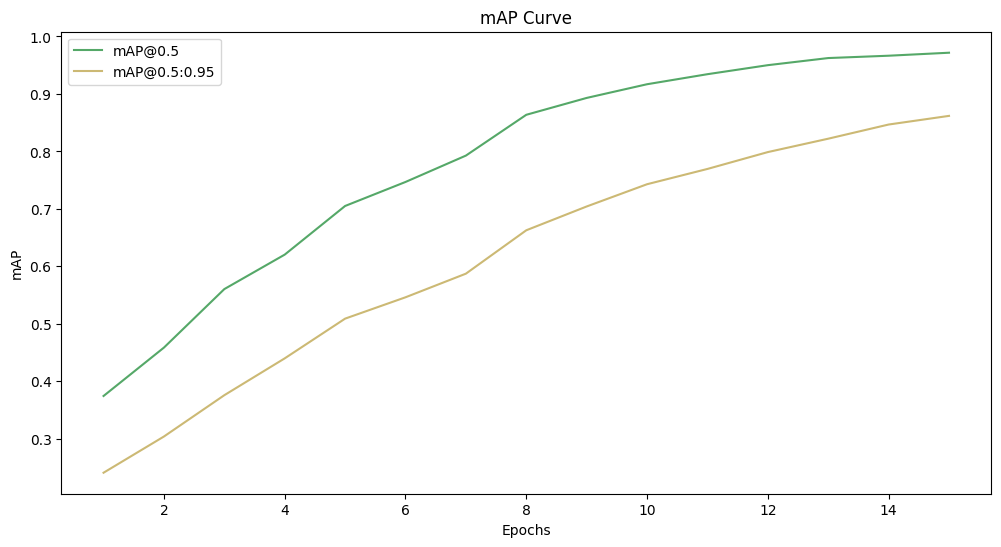

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load training results
csv_path = "/content/runs/segment/train4/results.csv"  # Update path if needed
df = pd.read_csv(csv_path)


# Plot mAP curves
plt.figure(figsize = (12, 6)) # Set the figure size
plt.plot(df["epoch"], df["metrics/mAP50(B)"], label = "mAP@0.5", color = "g") # plot mAP@0.5 curve
plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], label = "mAP@0.5:0.95", color = "y") # plot mAP@0.5:0.95 curve
plt.xlabel("Epochs") # Set the x-axis label
plt.ylabel("mAP")    # Set the y-axis label
plt.title("mAP Curve") # Set the title of the plot
plt.legend() # Show the legend
plt.show()   # Display the plot


# **Test the model on new images**

In [10]:
# Test the model
print("\nTesting the model...")
test_images_dir = "/content/drive/MyDrive/all_aug_anno_json_proj/Dataset/Yolo_conversions/test/images"  # Path to test images directory
test_results = model.predict(
    source = test_images_dir,  # Path to test images
    save = True,               # Save predictions
    save_txt = True,           # Save predictions as text files
    save_conf = True,          # Save confidence scores
    conf = 0.25,               # Confidence threshold
    iou = 0.45                 # IoU threshold

)




Testing the model...


WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1042 /content/drive/MyDrive/all_aug_anno_json_proj/Dataset/Yolo_conversions/test/images/10_aug_6.jpg: 480x640 2 Good Lane Lines, 1 Good Crash Barrier, 234.5ms
image 2/1042 /content/drive/MyDrive/all_aug_anno_json_proj/Dataset/Yolo_conversions/test/images/10_aug_8.jpg: 480x640 3 Good Lane Lines, 1 Good Crash Barrier, 24.8ms
image 3/1042 /content/drive/MyDrive/all_aug_anno_json_proj/Dataset/Yolo_conversions/test/images/11_au

# **Calculate performance metrics for predictions**

In [12]:
# Calculate performance metrics
# Note: You can analyze the test_results variable further for metrics like precision, recall, and F1-score.
print("\nPerformance Metrics:")
print(f"Number of test images: {len(test_results)}")
for result in test_results:
    print(f"Image: {result.path}, Predictions: {len(result.boxes)}")




Performance Metrics:
Number of test images: 1042
Image: /content/drive/MyDrive/all_aug_anno_json_proj/Dataset/Yolo_conversions/test/images/10_aug_6.jpg, Predictions: 3
Image: /content/drive/MyDrive/all_aug_anno_json_proj/Dataset/Yolo_conversions/test/images/10_aug_8.jpg, Predictions: 4
Image: /content/drive/MyDrive/all_aug_anno_json_proj/Dataset/Yolo_conversions/test/images/11_aug_10.jpg, Predictions: 5
Image: /content/drive/MyDrive/all_aug_anno_json_proj/Dataset/Yolo_conversions/test/images/11_aug_12.jpg, Predictions: 5
Image: /content/drive/MyDrive/all_aug_anno_json_proj/Dataset/Yolo_conversions/test/images/11_aug_5.jpg, Predictions: 5
Image: /content/drive/MyDrive/all_aug_anno_json_proj/Dataset/Yolo_conversions/test/images/11_aug_9.jpg, Predictions: 5
Image: /content/drive/MyDrive/all_aug_anno_json_proj/Dataset/Yolo_conversions/test/images/12_aug_12.jpg, Predictions: 1
Image: /content/drive/MyDrive/all_aug_anno_json_proj/Dataset/Yolo_conversions/test/images/12_aug_9.jpg, Prediction

# **Save the trained model (optional)**

In [16]:
# Optional: Save the trained model
!pip install onnx
model.export(format = "onnx", dynamic = True, simplify = True)
 # Save in ONNX format (you can choose other formats like 'torchscript', 'coreml', etc.)
# CUDA Dependency – If you're on CPU, some model export features might require changes.
# model.export(format="onnx", device="cpu")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 52.1 MB/s eta 0:00:00
Ultralytics 8.3.69 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from 'runs/segment/train4/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) ((1, 44, 8400), (1, 32, 160, 160)) (22.7 MB)
requirements: Ultralytics requirements ['onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.9/142.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 MB 234.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 204.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 228.6 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 37.6s, installed 2 packages: ['onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with 

'runs/segment/train4/weights/best.onnx'

#  **Summary of results**

In [17]:
# Print a summary of the training, validation, and test results
print("\nSummary:")
print(f"Training completed with {model.args['epochs']} epochs.")

# Bounding Box Metrics
print(f"Validation mAP@0.5: {val_results.box.map50:.4f}")  # Access map50 attribute of box property
print(f"Validation mAP@0.5:0.95: {val_results.box.map:.4f}") # Access map attribute of box property

# Segmentation Metrics
print(f"Validation mAP@0.5 (Segmentation): {val_results.seg.map50:.4f}")  # Access map50 attribute of seg property
print(f"Validation mAP@0.5:0.95 (Segmentation): {val_results.seg.map:.4f}")  # Access map attribute of seg property


Summary:
Training completed with 15 epochs.
Validation mAP@0.5: 0.9717
Validation mAP@0.5:0.95: 0.8620
Validation mAP@0.5 (Segmentation): 0.9640
Validation mAP@0.5:0.95 (Segmentation): 0.7553


# **Underfitting Vs Overfitting Plot**

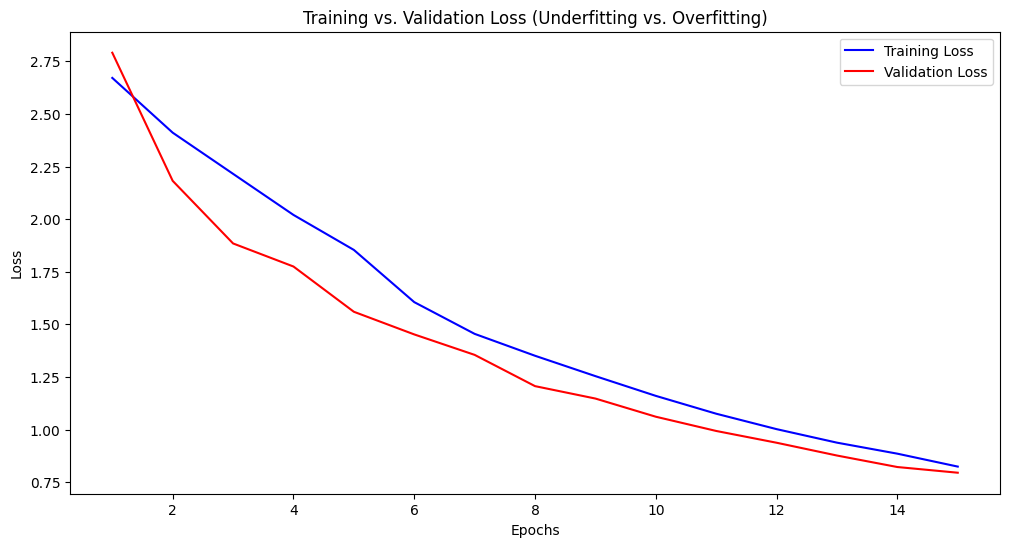

In [19]:
import pandas as pd # Import pandas for data manipulation
import matplotlib.pyplot as plt # Import matplotlib for plotting

# Load training results from the 'results.csv' file
csv_path = "/content/runs/segment/train4/results.csv"  # Update path if needed
df = pd.read_csv(csv_path)

# Plot Training and Validation Losses
plt.figure(figsize = (12, 6))
plt.plot(df['epoch'], df['train/seg_loss'], label = 'Training Loss', color = 'blue')
plt.plot(df['epoch'], df['val/seg_loss'], label = 'Validation Loss', color = 'red')

# Labels and Title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss (Underfitting vs. Overfitting)')

# Adding legend
plt.legend()

# Display the plot
plt.show()
